# Machine Learning for Equipment Failure Prediction and Equipment Maintenance (PM)

For more information on the topic please see the following article.

https://medium.com/swlh/machine-learning-for-equipment-failure-prediction-and-predictive-maintenance-pm-e72b1ce42da1


Published July 2020, Greatly revised February 2021.  Augmented and improved again in August 2022.

In this notebook, I walk through a predictive maintenance problem in great detail.  These types of issues can be tricky for several reasons.  The first six sections deal with building a model.  The last sections deal with evaluating model effectiveness and ensuring it will be effective when deployed in production.


When it comes to dealing with machines that require periodic maintenance, there are generally three possible outcomes.

One, you can maintain a machine too frequently. In other words, the machine gets maintenance when it is not required. In this scenario, you are throwing money out the window, wasting resources providing unnecessary maintenance. For example, you could change the oil in your car every single day. This is not optimal, and you will waste a lot of money on unnecessary maintenance.

Two, you don’t maintain your machine frequently enough. Failing to maintain a machine means that the machine will break while operating. Here, the costs could be substantial. Not only do you have the repair costs, but also costs associated with lost production. If a machine on the assembly line goes down, the line cannot produce anything. No production means lost profit. Also, you will incur legal and medical costs if injuries occurred as a result of the failure.

Three, a machine is maintained when it needs maintenance. This is obviously the better alternative of the three. Note, that that there is still a cost associated with timely maintenance.

So, we need to maintain machines when they need maintenance, right? Unfortunately, this is easier said than done. Fortunately, we can use predictive maintenance (PM) to predict when machines need maintenance.

I should also mention that most machines come with manufacturer recommendations on maintenance. The problem with manufacturer recommendations is that they represent an average. For example, cars on average need an oil change every 3,000 miles, but how frequently does your car need an oil change? It may be more or less than 3,000 miles depending on several factors, including where your drive, how you drive, and how frequently you drive.

Predictive maintenance (PM) can tell you, based on data, when a machine requires maintenance. An effective PM program will minimize under and over-maintaining your machine. For a large manufacturer with thousands of machines, being precise on machine maintenance can save millions of dollars every year.

In this article, I will examine a typical Predictive Maintenance (PM) use case. As I walk through this example, I will describe some of the issues that arise with PM problems and suggest ways to solve them.

An important note about the data used in this exercise. It is entirely fake. I created the data based on my experience of dealing with these types of problems. Although it is entirely artificial, I believe the data and use case is very realistic and consistent with many real PM problems.






The firm in our use case provided a sample of data that includes 421 machines that failed over two years. They spent 11.766M dollars on maintenance, most of which came from running machines until failure.

Here is a summary of the maintained or repaired machines over the last two years.

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://cdn-images-1.medium.com/max/1600/1*fUKUEUeqgIYU9xlxj4pwhw.png")

From the data above, it currently costs the firm about $28,000 per failed or maintained machine. Our goal is to lower this cost.

In the chart above, Timely Maintenance costs more than Unnecessary Maintenance. There is a good reason for this. For this machine, unnecessary maintenance means that that machine was moved off-line and checked, but the part in question showed insufficient wear to replace. Because parts were not replaced, there are no material costs, only labor.

Note that this company does very little predictive maintenance. Most of the time, they just run the machines to failure. Also, note that these machines will break in four to eight years if they don’t receive maintenance. When they fail, they must be pulled off-line and repaired.

Our goal is to show the firm how a Predictive Maintenance program can save them money. To do this, we will build a predictive model that predicts machine failure within 90 days of actual failure. Note that an appropriate failure window will always depend on the context of the problem. If a machine breaks without maintenance in 6 months, a three-month window makes no sense. Here, where a machine will run between 4 to 6 years without maintenance, a 90-day window is reasonable.

Our objective is to develop a solution that will lower the costs of failure. Again, it currently costs the firm about 28,000 per machine. We will attempt to reduce this cost.

Note that I developed this exercise in Watson Studio on the IBM Cloud.  If you have issues running the notebook, please set up a free account on IBM Cloud and try it there.
https://www.ibm.com/cloud/watson-studio


## Table of Contents

1. [Getting Setup](#setup1)<br>
 
2. [Data Exploration](#explore)<br>

3. [Data Transformation and Feature Engineering](#trans)<br>
 
4. [Dealing with the Small Number of Failures](#small)<br>
    4.1 [Expand the Failure Window](#window)<br>
    4.2 [Create Testing, Training and Validation Groups](#groups)<br>
    4.3 [SMOTE the Training Data](#smote)<br>
5. [More Data Transformations and Feature Engineering](#more)<br>
6. [Build the Model on the Balanced Data Set](#build)<br>
7. [Evaluate the model](#score)<br>
    7.1 [Evaluate the model using an AUC and accuacy metrics](#7.1)<br>
    7.2 [Evaluating with a Confusion Matrix](#7.2)<br>
    7.3 [Using Heuristics to Define a False Positive, True Positive, False Negative and True Negative](#7.3)<br>
    7.31 [Eliminate redundant failure signals](#7.31)<br>
    7.32 [Identify the machine id for each signal.  Identify the date of the failure signal.](#7.32)<br>
    7.33 [Create a realistic confusion matrix](#7.33)<br>
    7.34 [Incorporating the Economics of the Problem.](#7.34)<br>
    7.4 [Fine-Tuning  the solution.](#7.4)<br>
11. [Conclusions](#conc)<br>

### 1.0 Getting Set-Up <a></a>

In [2]:
!pip uninstall imbalanced-learn -y

In [3]:
#!pip install plotly 
#!pip install chart-studio 
#!pip install -U scikit-learn 

!pip install imbalanced-learn




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 68.7 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 2.2.0
    Uninstalling threadpoolctl-2.2.0:
      Successfully uninstalled threadpoolctl-2.2.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.0
    Uninstalling scikit-learn-1.3.0:
      Successfully uninstalled scikit-learn-1.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autoai-ts-libs 4.0.13 requires scikit-learn==1.3.*, but you have scikit-learn 1.6.1 which is incompatible.
autoai-libs 2.0.11 requires scikit-learn==1.3.*, but you have scikit-learn 1.6.1 which is incompatible.
lale 0.8.4 requires scikit-learn<1.5.0,>=1.0.0, but you have scikit-learn 1.6.1 which is

 Install all of the relevant Python Libraries

Import required libraries

In [4]:
#import chart_studio.plotly as py
#import plotly.graph_objs as go
#import plotly as plotly
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from sklearn import metrics

from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

import types
import pandas as pd

def __iter__(self): return 0




Import the data from GitHub.

In [5]:
#Remove the data if you run this notebook more than once
!rm equipment_failure_data_1.csv

rm: cannot remove 'equipment_failure_data_1.csv': No such file or directory


In [6]:
#import first half from github
!wget https://raw.githubusercontent.com/shadgriffin/machine_failure/master/equipment_failure_data_1.csv

--2025-01-24 18:59:54--  https://raw.githubusercontent.com/shadgriffin/machine_failure/master/equipment_failure_data_1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11219474 (11M) [text/plain]
Saving to: ‘equipment_failure_data_1.csv’

equipment_failure_d 100%[===================>]  10.70M  --.-KB/s    in 0.07s   

2025-01-24 18:59:55 (152 MB/s) - ‘equipment_failure_data_1.csv’ saved [11219474/11219474]



In [7]:
# Convert csv to pandas dataframe
pd_data_1 = pd.read_csv("equipment_failure_data_1.csv", sep=",", header=0)

In [9]:
pd_data_1.head()

,ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,S5,S16,S19,S18,EQUIPMENT_FAILURE,S8,AGE_OF_EQUIPMENT
0,100001,12/2/14,G,O,Y,1,11.088000,145.223448,39.34,3501.0,8.426869,1.9,24.610345,0,0.0,880
1,100001,12/3/14,G,O,Y,1,8.877943,187.573214,39.20,3489.0,6.483714,1.9,24.671429,0,0.0,881
2,100001,12/4/14,G,O,Y,1,8.676444,148.363704,38.87,3459.0,6.159659,2.0,24.733333,0,0.0,882
3,100001,12/5/14,G,O,Y,1,9.988338,133.660000,39.47,3513.0,9.320308,2.0,24.773077,0,0.0,883
4,100001,12/6/14,G,O,Y,1,8.475264,197.181600,40.33,3589.0,8.022960,1.5,24.808000,0,0.0,884


In [10]:
#Remove the data if you run this notebook more than once
!rm equipment_failure_data_2.csv

rm: cannot remove 'equipment_failure_data_2.csv': No such file or directory


In [11]:
#Import the second half from github
!wget https://raw.githubusercontent.com/shadgriffin/machine_failure/master/equipment_failure_data_2.csv

--2025-01-24 19:01:57--  https://raw.githubusercontent.com/shadgriffin/machine_failure/master/equipment_failure_data_2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11762512 (11M) [text/plain]
Saving to: ‘equipment_failure_data_2.csv’

equipment_failure_d 100%[===================>]  11.22M  --.-KB/s    in 0.06s   

2025-01-24 19:01:58 (175 MB/s) - ‘equipment_failure_data_2.csv’ saved [11762512/11762512]



In [12]:
# convert to pandas dataframe
pd_data_2 = pd.read_csv("equipment_failure_data_2.csv", sep=",", header=0)

In [13]:
pd_data_2.head()

,ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,S5,S16,S19,S18,EQUIPMENT_FAILURE,S8,AGE_OF_EQUIPMENT
0,100002,12/2/14,D,L,R,6,23.52,0.0,34.15,4064.0,7.842741,31.1,68.331034,0,0.0,820
1,100002,12/3/14,D,L,R,6,27.36,0.0,34.12,4060.0,8.089900,31.1,68.403571,0,0.0,821
2,100002,12/4/14,D,L,R,6,29.52,0.0,33.86,4029.0,9.657700,31.1,68.444444,0,0.0,822
3,100002,12/5/14,D,L,R,6,22.80,0.0,34.07,4054.0,6.520538,31.1,68.488462,0,0.0,823
4,100002,12/6/14,D,L,R,6,24.24,0.0,34.39,4093.0,9.161052,26.3,68.560000,0,0.0,824


In [14]:
#concatenate the two data files into one dataframe
pd_data=pd.concat([pd_data_1, pd_data_2])



### 2.0 Data Exploration <a></a>

In [15]:
pd_data.head()

,ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,S5,S16,S19,S18,EQUIPMENT_FAILURE,S8,AGE_OF_EQUIPMENT
0,100001,12/2/14,G,O,Y,1,11.088000,145.223448,39.34,3501.0,8.426869,1.9,24.610345,0,0.0,880
1,100001,12/3/14,G,O,Y,1,8.877943,187.573214,39.20,3489.0,6.483714,1.9,24.671429,0,0.0,881
2,100001,12/4/14,G,O,Y,1,8.676444,148.363704,38.87,3459.0,6.159659,2.0,24.733333,0,0.0,882
3,100001,12/5/14,G,O,Y,1,9.988338,133.660000,39.47,3513.0,9.320308,2.0,24.773077,0,0.0,883
4,100001,12/6/14,G,O,Y,1,8.475264,197.181600,40.33,3589.0,8.022960,1.5,24.808000,0,0.0,884


Now that we have the data imported into a Jupyter Notebook, we can explore it. Here is metadata explaining all of the fields in the data set.

ID — ID field that represents a specific machine.

DATE — The date of the observation.

REGION_CLUSTER — a field that represents the region in which the machine resides.

MAINTENANCE_VENDOR — a field that represents the company that provides maintenance and service to the machine.

MANUFACTURER — the company that manufactured the equipment in question.

WELL_GROUP — a field representing the type of machine.

EQUIPMENT_AGE — Age of the machine, in days.

S15 — A Sensor Value.

S17 — A Sensor Value.

S13 — A Sensor Value.

S16 — A Sensor Value.

S19 — A Sensor Value.

S18 — A Sensor Value.

S8 — A Sensor Value.

EQUIPMENT_FAILURE — A ‘1’ means that the equipment failed. A ‘0’ means the equipment did not fail.

Our first goal in this exercise is to build a model that predicts equipment failure. In other words, we will use the other variables in the data frame to predict EQUIPMENT_FAILURE.

Now we will walk through the data.




Examine the number of rows and columns.  The data has 307,751 rows and 16 columns.

In [16]:

pd_data.shape

(307751, 16)

There are 421 machines in the data set.

In [17]:

xxxx = pd.DataFrame(pd_data.groupby(['ID']).agg(['count']))
xxxx.shape

(421, 15)

there are 731 unique dates in the data set.

In [18]:

xxxx = pd.DataFrame(pd_data.groupby(['DATE']).agg(['count']))
xxxx.shape

(731, 15)

We have 731 unique dates.  So if we have 421 machines and 731 unique dates, we should have 307,751 total records.  Based on the .shape command, we have one record per machine per date value.  There are no duplicates in the data frame.



And to triple confirm, remove all duplicates and count the rows again.

In [19]:
df_failure_thingy=pd_data
df_failure_thingy=df_failure_thingy.drop_duplicates(subset=['ID','DATE'])
df_failure_thingy.shape


(307751, 16)

Look for null values in the fields -- There are none.

In [20]:
pd_data.isnull().sum(axis = 0)

ID                    0
DATE                  0
REGION_CLUSTER        0
MAINTENANCE_VENDOR    0
MANUFACTURER          0
WELL_GROUP            0
S15                   0
S17                   0
S13                   0
S5                    0
S16                   0
S19                   0
S18                   0
EQUIPMENT_FAILURE     0
S8                    0
AGE_OF_EQUIPMENT      0
dtype: int64

Now let’s examine the dependent variable in more detail. It appears that out of 307,751 records, we only have 421 failures. This corresponds to a failure rate of about .14%. In other words, for every failure, you have over 700 non-failures. This data set is very unbalanced. Later in this article, I will use a few techniques to mitigate the impact of a small number of observed failures.

In [21]:
xxxx = pd.DataFrame(pd_data.groupby(['EQUIPMENT_FAILURE'])['ID'].agg('count'))
xxxx

,ID
EQUIPMENT_FAILURE,
0,307330
1,421


We can also explore the data with descriptive statistics.

In [22]:

pd_data.describe()

,ID,WELL_GROUP,S15,S17,S13,S5,S16,S19,S18,EQUIPMENT_FAILURE,S8,AGE_OF_EQUIPMENT
count,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000
mean,100310.826603,4.543943,14.585192,80.265541,35.018249,4675.848252,7.972097,9.069123,137.963064,0.001368,144.665715,2524.192399
std,177.574390,2.284121,8.817056,85.804273,14.446585,2521.074632,2.321949,16.898887,238.890128,0.036961,240.773926,3158.930976
min,100001.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-16.490000,0.000000
25%,100161.000000,3.000000,7.694100,0.000000,28.200000,3209.000000,6.621500,0.900000,11.798276,0.000000,9.250000,721.000000
50%,100311.000000,5.000000,11.661600,31.680000,34.940000,4237.047619,8.004000,4.200000,38.200000,0.000000,53.080000,1113.000000
75%,100467.000000,6.000000,22.560000,160.080000,41.610000,5743.000000,9.460000,10.600000,150.900000,0.000000,165.092608,2784.000000
max,100617.000000,8.000000,59.040000,2555.520000,592.890000,52767.000000,24.600000,511.000000,4151.700000,1.000000,2068.110000,15170.000000


Examine a simple correlation of the independent variable with the dependent variable.  

In [25]:
xxx=pd_data.corr( method='pearson')

xxx=xxx[['EQUIPMENT_FAILURE']]
xxx['ABS_EQUIPMENT_FAILURE']=abs(xxx['EQUIPMENT_FAILURE'])
xxx=xxx.sort_values(by=['ABS_EQUIPMENT_FAILURE'], ascending=[False])

ValueError: could not convert string to float: '12/2/14'

In [24]:
xxx

NameError: name 'xxx' is not defined

SyntaxError: invalid syntax (3461125697.py, line 1)

### 3.0 Data transformations and Feature Engineering <a></a>

Next, we can transform our data for a machine learning model. Specifically, we will create running summaries of the sensor values. Running summaries of sensor values are often useful in predicting equipment failure. For example, if a temperature gauge indicates a machine is warmer than average for the last five days, it may mean something is wrong.

Remember that we are working with a panel data set. That is, we have multiple machines measured over two years. As we create our running summaries, we have to make sure that our summaries do not include more than one machine. For example, if we create a ten-day moving average, we do not want the first nine days of a machine to have values from the previous machine.

Note that I create twenty-one-day summaries in this example. This works for this use case, but it may be advantageous to use more or different time intervals for other situations.


Convert dates from character to date.

In [31]:


pd_data['DATE'] = pd.to_datetime(pd_data['DATE'])





/tmp/wsuser/ipykernel_173/2012639156.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd_data['DATE'] = pd.to_datetime(pd_data['DATE'])


Create a new field called “flipper” that indicates when the id changes as the data are sorted by ID and DATE in ascending order. We will use this in a few other transformations.

In [32]:
pd_data=pd_data.sort_values(by=['ID','DATE'], ascending=[True, True])

pd_data['flipper'] = np.where((pd_data.ID != pd_data.ID.shift(1)), 1, 0)
pd_data.head()

,ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,S5,S16,S19,S18,EQUIPMENT_FAILURE,S8,AGE_OF_EQUIPMENT,flipper
0,100001,2014-12-02,G,O,Y,1,11.088000,145.223448,39.34,3501.0,8.426869,1.9,24.610345,0,0.0,880,1
1,100001,2014-12-03,G,O,Y,1,8.877943,187.573214,39.20,3489.0,6.483714,1.9,24.671429,0,0.0,881,0
2,100001,2014-12-04,G,O,Y,1,8.676444,148.363704,38.87,3459.0,6.159659,2.0,24.733333,0,0.0,882,0
3,100001,2014-12-05,G,O,Y,1,9.988338,133.660000,39.47,3513.0,9.320308,2.0,24.773077,0,0.0,883,0
4,100001,2014-12-06,G,O,Y,1,8.475264,197.181600,40.33,3589.0,8.022960,1.5,24.808000,0,0.0,884,0


Running summaries are often useful transformations for these types of problems.  For example, a running mean would be the average value over the last x days.  X, in this case, is the feature window.  The feature window is a parameter that depends on the context of the business problem.  I am setting the value to 21 days, but this may or may not work for your business problem.

In [33]:
#define your feature window. This is the window by which we will aggregate our sensor values.
feature_window=21

Calculate the number of days from the first day a machine appears to the current day. This field will be called “TIME_SINCE_START” Also, create a variable called “too_soon.” When “too_soon” is equal to 1, we have less than 21 days (feature_window) of history for the machine.

We will use these new variables to create a running mean, median, max, and min. 


In [34]:
dfx=pd_data

In [35]:
#Select the first record of each machine

starter=dfx[dfx['flipper'] == 1]

starter=starter[['DATE','ID']]

In [36]:
#rename date to start_date
starter=starter.rename(index=str, columns={"DATE": "START_DATE"})

In [39]:
starter.shape

(421, 2)

In [40]:
#convert START_DATE to date
starter['START_DATE'] = pd.to_datetime(starter['START_DATE'])

In [41]:
#Merge START_DATE to the original data set

dfx=dfx.sort_values(by=['ID', 'DATE'], ascending=[True, True])
starter=starter.sort_values(by=['ID'], ascending=[True])
dfx =dfx.merge(starter, on=['ID'], how='left')

In [42]:
# calculate the number of days since the beginning of each well. 
dfx['C'] = dfx['DATE'] - dfx['START_DATE']
dfx['TIME_SINCE_START'] = dfx['C'] / np.timedelta64(1, 'D')
dfx=dfx.drop(columns=['C'])
dfx['too_soon'] = np.where((dfx.TIME_SINCE_START < feature_window) , 1, 0)

Create a running mean, max, min, and median for the sensor variables.

In [43]:
dfx['S5_mean'] = np.where((dfx.too_soon == 0),(dfx['S5'].rolling(min_periods=1, window=feature_window).mean()) , dfx.S5)
dfx['S5_median'] = np.where((dfx.too_soon == 0),(dfx['S5'].rolling(min_periods=1, window=feature_window).median()) , dfx.S5)
dfx['S5_max'] = np.where((dfx.too_soon == 0),(dfx['S5'].rolling(min_periods=1, window=feature_window).max()) , dfx.S5)
dfx['S5_min'] = np.where((dfx.too_soon == 0),(dfx['S5'].rolling(min_periods=1, window=feature_window).min()) , dfx.S5)


dfx['S13_mean'] = np.where((dfx.too_soon == 0),(dfx['S13'].rolling(min_periods=1, window=feature_window).mean()) , dfx.S13)
dfx['S13_median'] = np.where((dfx.too_soon == 0),(dfx['S13'].rolling(min_periods=1, window=feature_window).median()) , dfx.S13)
dfx['S13_max'] = np.where((dfx.too_soon == 0),(dfx['S13'].rolling(min_periods=1, window=feature_window).max()) , dfx.S13)
dfx['S13_min'] = np.where((dfx.too_soon == 0),(dfx['S13'].rolling(min_periods=1, window=feature_window).min()) , dfx.S13)


dfx['S15_mean'] = np.where((dfx.too_soon == 0),(dfx['S15'].rolling(min_periods=1, window=feature_window).mean()) , dfx.S15)
dfx['S15_median'] = np.where((dfx.too_soon == 0),(dfx['S15'].rolling(min_periods=1, window=feature_window).median()) , dfx.S15)
dfx['S15_max'] = np.where((dfx.too_soon == 0),(dfx['S15'].rolling(min_periods=1, window=feature_window).max()) , dfx.S15)
dfx['S15_min'] = np.where((dfx.too_soon == 0),(dfx['S15'].rolling(min_periods=1, window=feature_window).min()) , dfx.S15)

dfx['S16_mean'] = np.where((dfx.too_soon == 0),(dfx['S16'].rolling(min_periods=1, window=feature_window).mean()) , dfx.S16)
dfx['S16_median'] = np.where((dfx.too_soon == 0),(dfx['S16'].rolling(min_periods=1, window=feature_window).median()) , dfx.S16)
dfx['S16_max'] = np.where((dfx.too_soon == 0),(dfx['S16'].rolling(min_periods=1, window=feature_window).max()) , dfx.S16)
dfx['S16_min'] = np.where((dfx.too_soon == 0),(dfx['S16'].rolling(min_periods=1, window=feature_window).min()) , dfx.S16)


dfx['S17_mean'] = np.where((dfx.too_soon == 0),(dfx['S17'].rolling(min_periods=1, window=feature_window).mean()) , dfx.S17)
dfx['S17_median'] = np.where((dfx.too_soon == 0),(dfx['S17'].rolling(min_periods=1, window=feature_window).median()) , dfx.S17)
dfx['S17_max'] = np.where((dfx.too_soon == 0),(dfx['S17'].rolling(min_periods=1, window=feature_window).max()) , dfx.S17)
dfx['S17_min'] = np.where((dfx.too_soon == 0),(dfx['S17'].rolling(min_periods=1, window=feature_window).min()) , dfx.S17)

dfx['S18_mean'] = np.where((dfx.too_soon == 0),(dfx['S18'].rolling(min_periods=1, window=feature_window).mean()) , dfx.S18)
dfx['S18_median'] = np.where((dfx.too_soon == 0),(dfx['S18'].rolling(min_periods=1, window=feature_window).median()) , dfx.S18)
dfx['S18_max'] = np.where((dfx.too_soon == 0),(dfx['S18'].rolling(min_periods=1, window=feature_window).max()) , dfx.S18)
dfx['S18_min'] = np.where((dfx.too_soon == 0),(dfx['S18'].rolling(min_periods=1, window=feature_window).min()) , dfx.S18)



dfx['S19_mean'] = np.where((dfx.too_soon == 0),(dfx['S19'].rolling(min_periods=1, window=feature_window).mean()) , dfx.S19)
dfx['S19_median'] = np.where((dfx.too_soon == 0),(dfx['S19'].rolling(min_periods=1, window=feature_window).median()) , dfx.S19)
dfx['S19_max'] = np.where((dfx.too_soon == 0),(dfx['S19'].rolling(min_periods=1, window=feature_window).max()) , dfx.S19)
dfx['S19_min'] = np.where((dfx.too_soon == 0),(dfx['S19'].rolling(min_periods=1, window=feature_window).min()) , dfx.S19)


dfx.head()

,ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,S5,...,S17_max,S17_min,S18_mean,S18_median,S18_max,S18_min,S19_mean,S19_median,S19_max,S19_min
0,100001,2014-12-02,G,O,Y,1,11.088000,145.223448,39.34,3501.0,...,145.223448,145.223448,24.610345,24.610345,24.610345,24.610345,1.9,1.9,1.9,1.9
1,100001,2014-12-03,G,O,Y,1,8.877943,187.573214,39.20,3489.0,...,187.573214,187.573214,24.671429,24.671429,24.671429,24.671429,1.9,1.9,1.9,1.9
2,100001,2014-12-04,G,O,Y,1,8.676444,148.363704,38.87,3459.0,...,148.363704,148.363704,24.733333,24.733333,24.733333,24.733333,2.0,2.0,2.0,2.0
3,100001,2014-12-05,G,O,Y,1,9.988338,133.660000,39.47,3513.0,...,133.660000,133.660000,24.773077,24.773077,24.773077,24.773077,2.0,2.0,2.0,2.0
4,100001,2014-12-06,G,O,Y,1,8.475264,197.181600,40.33,3589.0,...,197.181600,197.181600,24.808000,24.808000,24.808000,24.808000,1.5,1.5,1.5,1.5


Another useful transformation is to look for sudden spikes in sensor values. This code creates a value indicating how far the current value is from the immediate norm.

In [44]:
dfx['S5_chg'] = np.where((dfx.S5_mean == 0),0 , dfx.S5/dfx.S5_mean)


dfx['S13_chg'] = np.where((dfx.S13_mean == 0),0 , dfx.S13/dfx.S13_mean)

dfx['S15_chg'] = np.where((dfx.S15_mean==0),0 , dfx.S15/dfx.S15_mean)
dfx['S16_chg'] = np.where((dfx.S16_mean == 0),0 , dfx.S16/dfx.S16_mean)
dfx['S17_chg'] = np.where((dfx.S17_mean == 0),0 , dfx.S17/dfx.S17_mean)
dfx['S18_chg'] = np.where((dfx.S18_mean == 0),0 , dfx.S18/dfx.S18_mean)
dfx['S19_chg'] = np.where((dfx.S19_mean == 0),0 , dfx.S19/dfx.S19_mean)

In [45]:
#copy the data set to the original name
pd_data=dfx

### 4.0 Dealing with the small number of failures. <a></a>

#### 4.1 Expand the Failure (Target) Window <a></a>

Machines are engineered to last. If something breaks all the time, you won’t buy it, would you?

Because machines generally last a long time, we typically do not have many examples of failure. This means the data sets we use in PM are almost always unbalanced. 

One way to increase the number of failures is to expand the failure or target window. That is, make the dependent variable, not just the day the equipment failed but the 28 days (or another appropriate interval) leading up to the failure.

In this example, I use a 28-day target window. We will use the 28 days leading up to a failure as the dependent variable in our model.


In [46]:
target_window=28

Sort the data and reset the index.

In [47]:
pd_data=pd_data.sort_values(by=['ID', 'DATE'], ascending=[True, True])
pd_data.reset_index(level=0, inplace=True)

Create a new data frame that contains the failure records.  Rename DATE to FAILURE_DATE

In [48]:


df_failure_thingy=pd_data[pd_data['EQUIPMENT_FAILURE'] == 1]

df_failure_thingy=df_failure_thingy[['DATE','ID']]

df_failure_thingy=df_failure_thingy.rename(index=str, columns={"DATE": "FAILURE_DATE"})

pd_data=pd_data.sort_values(by=['ID'], ascending=[True])
df_failure_thingy=df_failure_thingy.sort_values(by=['ID'], ascending=[True])


Append the FAILURE_DATE to each ID.

In [49]:


pd_data =pd_data.merge(df_failure_thingy, on=['ID'], how='left')

For each record, calculate the number of days until failure.

In [50]:


pd_data=pd_data.sort_values(by=['ID','DATE'], ascending=[True, True])

pd_data['FAILURE_DATE'] = pd.to_datetime(pd_data['FAILURE_DATE'])
pd_data['DATE'] = pd.to_datetime(pd_data['DATE'])
pd_data['C'] = pd_data['FAILURE_DATE'] - pd_data['DATE']

pd_data['TIME_TO_FAILURE'] = pd_data['C'] / np.timedelta64(1, 'D')

Clean up and sort the records by ID and DATE

In [51]:
pd_data=pd_data.drop(columns=['index'])

In [52]:
pd_data=pd_data.sort_values(by=['ID', 'DATE'], ascending=[True, True])



In [53]:
pd_data.reset_index(inplace=True)


In [54]:
pd_data.head()

,index,ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,...,S5_chg,S13_chg,S15_chg,S16_chg,S17_chg,S18_chg,S19_chg,FAILURE_DATE,C,TIME_TO_FAILURE
0,0,100001,2014-12-02,G,O,Y,1,11.088000,145.223448,39.34,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,143 days,143.0
1,549,100001,2014-12-03,G,O,Y,1,8.877943,187.573214,39.20,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,142 days,142.0
2,483,100001,2014-12-04,G,O,Y,1,8.676444,148.363704,38.87,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,141 days,141.0
3,484,100001,2014-12-05,G,O,Y,1,9.988338,133.660000,39.47,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,140 days,140.0
4,485,100001,2014-12-06,G,O,Y,1,8.475264,197.181600,40.33,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,139 days,139.0


Create a new variable, FAILURE_TARGET.  It is equal to 1 if the record proceeds a failure by "failure_window" days or less.

In [55]:
pd_data['FAILURE_TARGET'] = np.where(((pd_data.TIME_TO_FAILURE < target_window) & ((pd_data.TIME_TO_FAILURE>=0))), 1, 0)

pd_data.head()

,index,ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,...,S13_chg,S15_chg,S16_chg,S17_chg,S18_chg,S19_chg,FAILURE_DATE,C,TIME_TO_FAILURE,FAILURE_TARGET
0,0,100001,2014-12-02,G,O,Y,1,11.088000,145.223448,39.34,...,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,143 days,143.0,0
1,549,100001,2014-12-03,G,O,Y,1,8.877943,187.573214,39.20,...,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,142 days,142.0,0
2,483,100001,2014-12-04,G,O,Y,1,8.676444,148.363704,38.87,...,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,141 days,141.0,0
3,484,100001,2014-12-05,G,O,Y,1,9.988338,133.660000,39.47,...,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,140 days,140.0,0
4,485,100001,2014-12-06,G,O,Y,1,8.475264,197.181600,40.33,...,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,139 days,139.0,0


In [56]:
tips_summed = pd_data.groupby(['FAILURE_TARGET'])['S5'].count()
tips_summed

FAILURE_TARGET
0    296011
1     11740
Name: S5, dtype: int64

The new field occurs about 4% of the time.

In [57]:
pd_data['FAILURE_TARGET'].mean()

0.03814772332177637

Now we have 11,740 target observations. This is better, but the data set is far from balanced. In the next section, we will use SMOTE to increase the number of failures synthetically. However, let’s split our data into training, testing, and a validation sample before we do that.

#### 4.2 Create the Testing, Training and Validation Groupings <a></a>

Because we are dealing with a panel data set (cross-sectional time-series), it is better not to take a random sample of all records. Doing so would put the records from one machine in all three sample data sets. To avoid this, we’ll randomly select IDs and place all of the records for each machine in either the training, testing, or validation data set.

In [58]:
#Get a Unique List of All IDs 


aa=pd_data

pd_id=aa.drop_duplicates(subset='ID')
pd_id=pd_id[['ID']]
pd_id.shape


(421, 1)

Create a new variable with a random number between 0 and 1

In [60]:
np.random.seed(42)

In [61]:
pd_id['wookie'] = (np.random.randint(0, 10000, pd_id.shape[0]))/10000

In [62]:

pd_id=pd_id[['ID', 'wookie']]

Give each record a 30% chance of being in the validation, a 35% chance of being in the testing, and a 35% chance of being in the training data set.


In [63]:
pd_id['MODELING_GROUP'] = np.where(((pd_id.wookie <= 0.35)), 'TRAINING', np.where(((pd_id.wookie <= 0.65)), 'VALIDATION', 'TESTING'))

This is how many machines fall in each group.

In [65]:
tips_summed = pd_id.groupby(['MODELING_GROUP'])['wookie'].count()
tips_summed

MODELING_GROUP
TESTING       149
TRAINING      146
VALIDATION    126
Name: wookie, dtype: int64

Append the Group of each id to each individual record.

In [66]:
pd_data=pd_data.sort_values(by=['ID'], ascending=[True])
pd_id=pd_id.sort_values(by=['ID'], ascending=[True])

In [67]:
pd_data =pd_data.merge(pd_id, on=['ID'], how='inner')

pd_data.head()

,index,ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,...,S16_chg,S17_chg,S18_chg,S19_chg,FAILURE_DATE,C,TIME_TO_FAILURE,FAILURE_TARGET,wookie,MODELING_GROUP
0,0,100001,2014-12-02,G,O,Y,1,11.088,145.223448,39.34,...,1.000000,1.0,1.000000,1.000000,2015-04-24,143 days,143.0,0,0.727,TESTING
1,1,100001,2016-03-29,G,O,Y,1,18.960,0.000000,38.87,...,1.080334,0.0,0.909801,0.613483,2015-04-24,-340 days,-340.0,0,0.727,TESTING
2,2,100001,2016-03-30,G,O,Y,1,29.040,0.000000,37.36,...,1.093691,0.0,0.906040,0.677419,2015-04-24,-341 days,-341.0,0,0.727,TESTING
3,3,100001,2016-03-31,G,O,Y,1,18.000,0.000000,38.81,...,0.910905,0.0,0.919466,0.695035,2015-04-24,-342 days,-342.0,0,0.727,TESTING
4,4,100001,2016-04-01,G,O,Y,1,26.160,0.000000,39.47,...,1.160104,0.0,0.932363,0.690141,2015-04-24,-343 days,-343.0,0,0.727,TESTING


This is how many records are in each group.

In [68]:
tips_summed = pd_data.groupby(['MODELING_GROUP'])['wookie'].count()
tips_summed

MODELING_GROUP
TESTING       108919
TRAINING      106726
VALIDATION     92106
Name: wookie, dtype: int64

This is how many failure targets are in each group.

In [69]:
tips_summed = pd_data.groupby(['MODELING_GROUP'])['FAILURE_TARGET'].sum()
tips_summed

MODELING_GROUP
TESTING       4151
TRAINING      4071
VALIDATION    3518
Name: FAILURE_TARGET, dtype: int64

Create a separate data frame for the training data.  We will use this data set to build the model.

In [70]:
df_training=pd_data[pd_data['MODELING_GROUP'] == 'TRAINING']
df_training=df_training.drop(columns=['MODELING_GROUP','C','wookie','TIME_TO_FAILURE','flipper','START_DATE'])
df_training.shape

(106726, 56)

Create a separate data frame for the training and testing data sets.  We will use this to tweak our modeling results.

In [71]:
df_train_test=pd_data[pd_data['MODELING_GROUP'] != 'VALIDATION']

df_train_test=df_train_test.drop(columns=['wookie','TIME_TO_FAILURE','flipper','START_DATE'])
df_train_test.shape

(215645, 58)

Create a separate data frame for all the data. We will use this to validate the model and compare the accuracy of all groups.

In [72]:
df_total=pd_data.drop(columns=['C','wookie','TIME_TO_FAILURE','flipper','START_DATE'])
df_total.shape

(307751, 57)

#### 4.3 SMOTE the Training Data <a></a>

Note that we are only balancing the training data set. You may be asking why. Remember that our goal is to build a model the represents reality, right? When we SMOTE the data, we change the failure rate to 50%. This is nowhere near what we see in the actual machine data.  Thus, it makes sense to build the model on the SMOTE data but evaluate it on the unaltered data. The unaltered data will be a better reflection of what to expect when you deploy the model to production.

Define the Training features and Target.

In [73]:
training_features=df_training[['REGION_CLUSTER','MAINTENANCE_VENDOR','MANUFACTURER','WELL_GROUP','AGE_OF_EQUIPMENT','S15','S17','S13','S5',
 'S16','S19','S18','S8','S5_mean','S5_median','S5_max','S5_min','S13_mean','S13_median','S13_max','S13_min','S15_mean','S15_median',
 'S15_max','S15_min','S16_mean','S16_median','S16_max','S16_min','S17_mean','S17_median','S17_max','S17_min','S18_mean','S18_median','S18_max','S18_min','S19_mean','S19_median','S19_max','S19_min',
 'S5_chg','S13_chg','S15_chg','S16_chg','S17_chg','S18_chg','S19_chg']]

In [74]:
training_target=df_training[['FAILURE_TARGET']]

Synthetically Balance the training data sets with a SMOTE algorithm. After we apply the SMOTE algorithm, we will have a balanced data set. 50% Failures and 50% Non-Failures. Note that this takes a while to run.

In [75]:
#uncomment these options if you want to expand the number of rows and columns that appear visually on the screen.

#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [77]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
smx = SMOTENC(random_state=12,  categorical_features=[0, 1, 2, 3])

In [78]:
x_res, y_res = smx.fit_resample(training_features, training_target.values.ravel())

Convert the SMOTE output back to complete data frames with independent and dependent variables.  Examine the results.

Format the Independent Variables.

In [79]:
df_x=pd.DataFrame(x_res)

df_x.columns = [
 'REGION_CLUSTER','MAINTENANCE_VENDOR','MANUFACTURER','WELL_GROUP','AGE_OF_EQUIPMENT','S15','S17','S13','S5','S16','S19',
 'S18','S8','S5_mean','S5_median','S5_max','S5_min','S13_mean','S13_median','S13_max','S13_min','S15_mean','S15_median','S15_max',
 'S15_min','S16_mean','S16_median','S16_max','S16_min','S17_mean','S17_median','S17_max','S17_min','S18_mean','S18_median','S18_max','S18_min',
 'S19_mean','S19_median','S19_max','S19_min','S5_chg','S13_chg','S15_chg','S16_chg','S17_chg','S18_chg','S19_chg']
df_x.head()

,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,AGE_OF_EQUIPMENT,S15,S17,S13,S5,S16,...,S19_median,S19_max,S19_min,S5_chg,S13_chg,S15_chg,S16_chg,S17_chg,S18_chg,S19_chg
0,D,L,R,6,1308,15.5184,188.10,36.29,4318.0,8.0073,...,22.4,28.9,22.4,0.989654,0.989779,1.208706,0.913224,1.150727,0.995684,0.911805
1,D,L,R,6,1307,10.3032,149.24,36.78,4377.0,7.0766,...,22.4,28.9,22.4,1.001165,1.001141,0.800762,0.799231,0.931453,0.991996,0.911805
2,D,L,R,6,1306,11.4480,187.45,35.84,4265.0,8.0259,...,22.4,28.9,22.4,0.974444,0.974443,0.886546,0.906484,1.158515,0.985806,0.911805
3,D,L,R,6,1302,15.1368,148.33,37.53,4466.0,8.7163,...,22.4,28.9,22.4,1.015319,1.015344,1.168344,0.992329,0.922866,0.973863,0.911805
4,D,L,R,6,1304,14.3736,179.30,36.31,4321.0,7.9396,...,22.4,28.9,22.4,0.983099,0.983085,1.094500,0.902220,1.132530,0.980886,0.911805


Format the Dependent Variable.

In [80]:
df_y=pd.DataFrame(y_res)
df_y.columns = ['FAILURE_TARGET']

Check that the dependent variable is balanced.  It is.

In [81]:
df_y.mean(axis = 0) 

FAILURE_TARGET    0.5
dtype: float64

Merge the dependent and independent variables post SMOTE into a data frame.

In [82]:
df_balanced = pd.concat([df_y, df_x], axis=1)
df_balanced.head()

,FAILURE_TARGET,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,AGE_OF_EQUIPMENT,S15,S17,S13,S5,...,S19_median,S19_max,S19_min,S5_chg,S13_chg,S15_chg,S16_chg,S17_chg,S18_chg,S19_chg
0,0,D,L,R,6,1308,15.5184,188.10,36.29,4318.0,...,22.4,28.9,22.4,0.989654,0.989779,1.208706,0.913224,1.150727,0.995684,0.911805
1,0,D,L,R,6,1307,10.3032,149.24,36.78,4377.0,...,22.4,28.9,22.4,1.001165,1.001141,0.800762,0.799231,0.931453,0.991996,0.911805
2,0,D,L,R,6,1306,11.4480,187.45,35.84,4265.0,...,22.4,28.9,22.4,0.974444,0.974443,0.886546,0.906484,1.158515,0.985806,0.911805
3,0,D,L,R,6,1302,15.1368,148.33,37.53,4466.0,...,22.4,28.9,22.4,1.015319,1.015344,1.168344,0.992329,0.922866,0.973863,0.911805
4,0,D,L,R,6,1304,14.3736,179.30,36.31,4321.0,...,22.4,28.9,22.4,0.983099,0.983085,1.094500,0.902220,1.132530,0.980886,0.911805


### 5.0 More data transformation and feature engineering <a></a>

Convert the categorical variables into binary dummy variables. We need to do this because the XGBT model (below) doesn't like categorical fields.

In [83]:
df_dv = pd.get_dummies(df_balanced['REGION_CLUSTER'])

df_dv=df_dv.rename(columns={"A": "CLUSTER_A","B":"CLUSTER_B","C":"CLUSTER_C","D":"CLUSTER_D","E":"CLUSTER_E","F":"CLUSTER_F","G":"CLUSTER_G","H":"CLUSTER_H"})


df_balanced= pd.concat([df_balanced, df_dv], axis=1)


df_dv = pd.get_dummies(df_balanced['MAINTENANCE_VENDOR'])

df_dv=df_dv.rename(columns={"I": "MV_I","J":"MV_J","K":"MV_K","L":"MV_L","M":"MV_M","N":"MV_N","O":"MV_O","P":"MV_P"})


df_balanced = pd.concat([df_balanced, df_dv], axis=1)



df_dv = pd.get_dummies(df_balanced['MANUFACTURER'])

df_dv=df_dv.rename(columns={"Q": "MN_Q","R":"MN_R","S":"MN_S","T":"MN_T","U":"MN_U","V":"MN_V","W":"MN_W","X":"MN_X","Y":"MN_Y","Z":"MN_Z"})


df_balanced = pd.concat([df_balanced, df_dv], axis=1)


df_dv = pd.get_dummies(df_balanced['WELL_GROUP'])

df_dv=df_dv.rename(columns={1: "WG_1",2:"WG_2",3:"WG_3",4:"WG_4",5:"WG_5",6:"WG_6",7:"WG_7",8:"WG_8"})


df_balanced = pd.concat([df_balanced, df_dv], axis=1)


Execute the same transformation on the train_test data set.

In [84]:
df_dv = pd.get_dummies(df_train_test['REGION_CLUSTER'])

df_dv=df_dv.rename(columns={"A": "CLUSTER_A","B":"CLUSTER_B","C":"CLUSTER_C","D":"CLUSTER_D","E":"CLUSTER_E","F":"CLUSTER_F","G":"CLUSTER_G","H":"CLUSTER_H"})


df_train_test= pd.concat([df_train_test, df_dv], axis=1)


df_dv = pd.get_dummies(df_train_test['MAINTENANCE_VENDOR'])

df_dv=df_dv.rename(columns={"I": "MV_I","J":"MV_J","K":"MV_K","L":"MV_L","M":"MV_M","N":"MV_N","O":"MV_O","P":"MV_P"})


df_train_test = pd.concat([df_train_test, df_dv], axis=1)



df_dv = pd.get_dummies(df_train_test['MANUFACTURER'])

df_dv=df_dv.rename(columns={"Q": "MN_Q","R":"MN_R","S":"MN_S","T":"MN_T","U":"MN_U","V":"MN_V","W":"MN_W","X":"MN_X","Y":"MN_Y","Z":"MN_Z"})


df_train_test = pd.concat([df_train_test, df_dv], axis=1)


df_dv = pd.get_dummies(df_train_test['WELL_GROUP'])

df_dv=df_dv.rename(columns={1: "WG_1",2:"WG_2",3:"WG_3",4:"WG_4",5:"WG_5",6:"WG_6",7:"WG_7",8:"WG_8"})


df_train_test = pd.concat([df_train_test, df_dv], axis=1)



And, also on the df_total data set.

In [85]:
df_dv = pd.get_dummies(df_total['REGION_CLUSTER'])

df_dv=df_dv.rename(columns={"A": "CLUSTER_A","B":"CLUSTER_B","C":"CLUSTER_C","D":"CLUSTER_D","E":"CLUSTER_E","F":"CLUSTER_F","G":"CLUSTER_G","H":"CLUSTER_H"})


df_total= pd.concat([df_total, df_dv], axis=1)


df_dv = pd.get_dummies(df_total['MAINTENANCE_VENDOR'])

df_dv=df_dv.rename(columns={"I": "MV_I","J":"MV_J","K":"MV_K","L":"MV_L","M":"MV_M","N":"MV_N","O":"MV_O","P":"MV_P"})


df_total = pd.concat([df_total, df_dv], axis=1)



df_dv = pd.get_dummies(df_total['MANUFACTURER'])

df_dv=df_dv.rename(columns={"Q": "MN_Q","R":"MN_R","S":"MN_S","T":"MN_T","U":"MN_U","V":"MN_V","W":"MN_W","X":"MN_X","Y":"MN_Y","Z":"MN_Z"})


df_total = pd.concat([df_total, df_dv], axis=1)


df_dv = pd.get_dummies(df_total['WELL_GROUP'])

df_dv=df_dv.rename(columns={1: "WG_1",2:"WG_2",3:"WG_3",4:"WG_4",5:"WG_5",6:"WG_6",7:"WG_7",8:"WG_8"})


df_total = pd.concat([df_total, df_dv], axis=1)

### 6.0 Build the model on the balanced training data set <a></a>

In [86]:
# Remove the newly redundant categorical variables.  This are now represented by dummy variables.
df_balanced=df_balanced.drop(columns=['REGION_CLUSTER','MAINTENANCE_VENDOR','MANUFACTURER','WELL_GROUP'])

In the balanced data set, separate the dependent and independent variables to feed the model development process.

In [87]:

features = [x for x in df_balanced.columns if x not in ['FAILURE_TARGET']]  
dependent=pd.DataFrame(df_balanced['FAILURE_TARGET'])

independent=df_balanced.drop(columns=['FAILURE_TARGET'])

In [88]:
#make sure everything is numeric for simplicity -- this caused issues with some operating environments, so it is commented out.
#independent = independent.apply(pd.to_numeric) 
#df_balanced = df_balanced.apply(pd.to_numeric)

Define model specs.

In [89]:
df_balanced.head(1)

,FAILURE_TARGET,AGE_OF_EQUIPMENT,S15,S17,S13,S5,S16,S19,S18,S8,...,MN_Y,MN_Z,WG_1,WG_2,WG_3,WG_4,WG_5,WG_6,WG_7,WG_8
0,0,1308,15.5184,188.1,36.29,4318.0,8.0073,22.4,143.9,222.64,...,False,False,False,False,False,False,False,True,False,False


In [90]:
import matplotlib.pylab as plt
%matplotlib inline

def evaluate_model(alg, train, target, predictors,  early_stopping_rounds=1):
    
   
    #Fit the algorithm on the data
    alg.fit(train[predictors], target['FAILURE_TARGET'], eval_metric='error')
        
    #Predict training set:
    dtrain_predictions = alg.predict(train[predictors])
    dtrain_predprob = alg.predict_proba(train[predictors])[:,1]
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False) 
    feat_imp.plot(kind='bar', title='Feature Importance', color='g') 
    plt.ylabel('Feature Importance Score')
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(target['FAILURE_TARGET'].values, dtrain_predictions))
    print("AUC Score (Balanced): %f" % metrics.roc_auc_score(target['FAILURE_TARGET'], dtrain_predprob))

Define the parameter values for a xgbt model

In [92]:
estimator_vals=160
lr_vals = 0.8
md_vals = 12
mcw_vals = 0.5
gamma_vals =.1
subsample_vals = .5
c_bt_vals = 1
reg_lambda_vals = 1
reg_alpha_vals = 1

Define the model

In [93]:
xgb0 = XGBClassifier(objective = 'binary:logistic',use_label_encoder=False,learning_rate = lr_vals,
n_estimators=estimator_vals,max_depth=md_vals,min_child_weight=mcw_vals,
gamma=gamma_vals,subsample=subsample_vals,colsample_bytree=c_bt_vals,
reg_lambda=reg_lambda_vals,reg_alpha=reg_alpha_vals);


Build the model on the balanced training data set.

/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



Model Report
Accuracy : 1
AUC Score (Balanced): 1.000000


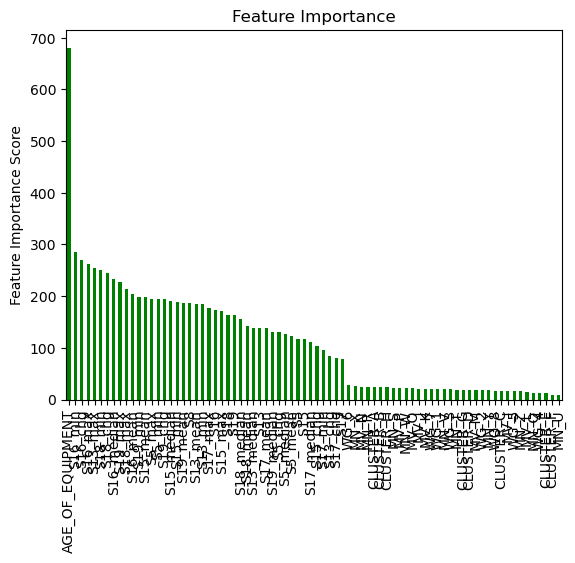

In [94]:
evaluate_model(xgb0, independent, dependent,features) 

Well, the model is perfect! So we can go home and celebrate? 


Ummm, ..., not so fast. Let's see how the model performs on the original non-balanced training data and the hold-out testing data.

### 7.0 Evaluate the Model <a></a>

The most confusing element of PM problems is building a realistic model assessment.  Because of timing and the small number of failures, understanding how the model will work once deployed in production is challenging. 

There are standard metrics for evaluating models like accuracy, AUC, and a confusion matrix.  In the sections below, I will show how, given the transformations we used to build our model and the complexity of the problem, these metrics do not give us a realistic view of model performance when deployed into production.  These standard metrics are helpful but are not sufficient.


#### 7.1 Evaluate the model using an AUC and accuracy metrics.<a></a>

We've already established that the model predicts the balanced training data with 100 percent accuracy. In this section, we will gauge the model's accuracy using unbalanced training and testing data. The first step is to split the original data frame into two—one data frame for testing and a second for training.

In [95]:

df_testing=df_train_test[df_train_test['MODELING_GROUP'] == 'TESTING'].copy()
df_training=df_train_test[df_train_test['MODELING_GROUP'] != 'TESTING'].copy()

Now, we will evaluate the unbalanced training data.

In [98]:


df_training['P_FAIL']= xgb0.predict_proba(df_training[features])[:,1];
df_training['Y_FAIL'] = np.where(((df_training.P_FAIL <= .50)), 0, 1)
#Print model report:
print("Accuracy : %.4g" % metrics.accuracy_score(df_training['FAILURE_TARGET'].values, df_training['Y_FAIL']))
print("AUC Score (Train): %f" % metrics.roc_auc_score(df_training['FAILURE_TARGET'], df_training['P_FAIL']))

Accuracy : 1
AUC Score (Train): 1.000000


Yeah Baby! Still perfect!  

Ok, don't get too excited.  Let's take a look at the hold-out testing data set.  Let's look at the testing data set with a .50 cut-off.

In [99]:
df_testing['P_FAIL']= xgb0.predict_proba(df_testing[features])[:,1];
df_testing['Y_FAIL'] = np.where(((df_testing.P_FAIL <= .50)), 0, 1)
#Print model report:
print("Accuracy : %.4g" % metrics.accuracy_score(df_testing['FAILURE_TARGET'].values, df_testing['Y_FAIL']))
print("AUC Score (Train): %f" % metrics.roc_auc_score(df_testing['FAILURE_TARGET'], df_testing['P_FAIL']))

Accuracy : 0.954
AUC Score (Train): 0.505015


Before we go any further, let's take a step back and consider what we have done.  Our model validates with an accuracy of .9537.  

Is that good or bad?  

At this point, I honestly have no idea.  What does this say about how this model will perform in production?  How much will this model improve operations over "Business as Usual"? 

We can not answer the questions above with an accuracy metric.  It is not possible.  To fully grasp how a PM model will perform, you must put it into the context of its deployment.  

#### 7.2 Evaluate the model using a simple confusion matrix.<a></a>

We've established that the model perfectly fits the training data, so we won't waste time evaluating the training data.

Let's take a look at the testing data.  First, we will cross-tabulate predicted failure with the original failure variable, 'EQUIPMENT_FAILURE".  Note this is the initial failure variable.  The one with only 421 values.  The other side of the confusion matrix is the predicted binary variable "Y_FAIL."  Remember, we used a 0.50 cut-off to define this variable.

In [100]:

print(pd.crosstab(df_testing.Y_FAIL, df_testing.EQUIPMENT_FAILURE, dropna=False))

EQUIPMENT_FAILURE       0    1
Y_FAIL                        
0                  107841  147
1                     929    2


The 'EQUIPMENT_FAILURE' variable identifies a failure on the day it occurs. Let's say that failure occurs on Friday, and we have failure signals on Monday, Tuesday, Wednesday, and Thursday, but not on Friday. I would argue that the failure on Friday is a True Positive, given that there were four failure signals in the days leading up to the failure. However, the confusion matrix above counts Monday, Tuesday, Wednesday, and Thursday as false positives and Friday as a false negative. This cross-tab alone doesn't give us a realistic view of how the model will perform in production.

Now, we will create a confusion matrix using 'FAILURE_TARGET.' This variable is the predicted binary variable where the 28 days leading up to a failure are flagged as failures. 

In [101]:
print(pd.crosstab(df_testing.Y_FAIL, df_testing.FAILURE_TARGET, dropna=False))

FAILURE_TARGET       0     1
Y_FAIL                      
0               103874  4114
1                  894    37


With 'FAILURE_TARGET,' we have 48 True Positives, 4,103 False Negatives, 940 False Positives, and 103,328 True Negatives.  

Does this work?  

Not really, huh?  Think about it.  

Each failure is represented 28 different times.  If a machine fails on Friday the 28th, the previous twenty-seven days of the month are also flagged as a failure.  This clearly won't work, will it?

The example above clearly does not reflect what we can expect when we push this model into production.  To get a realistic evaluation of the model, we must have practical definitions of false positives, false negatives, true negatives, and false negatives.     

#### 7.3 Using Heuristics to Define a False Positive, True Positive, False Negative, and True Negative.<a></a>

We first need to define a few parameters to evaluate our machine learning model accurately.  I usually fine-tune these parameters with the testing and training data sets, then confirm the accuracy with the validation data set.

The first parameter is the Forecast Window.  

The Forecast Window is the length of time a failure signal projects into the future.  

For example, if there is a failure signal on June 1st, how long does that signal last?  

Does it mean the machine will break in the next second, minute, hour, day, or month? 

Note that the forecast window length depends on the problem's context.  If a machine runs to failure in 10 years, the forecast window will be relatively long, perhaps as long as six or nine months.  If a machine runs to failure in 1 day, the forecast window will be much shorter, maybe an hour or a few minutes.  The length of the forecast window must be helpful to the problem.  For example, a twenty-eight-day forecast window for a machine that runs to failure in thirty days is of little value.  

In our current use case, the machine runs to failure in four to six years, so a ninety-day forecast window is reasonable.

We also need to define a cut-off value.  In this first example, we will use a cut-off value of .50.  The cut-off value determines if a prediction is a failure or a non-failure.  In the current example, if the probability of failure is less than .5, it is a predicted non-failure.  If the likelihood of failure is greater than .5, it is an expected failure.

In [102]:
forecast_window=90
cutoff=0.50


Create a probability of failure for the df_train_test data set.  Note this has both the unbalanced training data and the unbalanced testing data.  Once the probability is defined, create a "Fail/No Fail" binary variable using the cut-off value.

In [103]:
df=df_train_test

In [104]:
df['P_FAIL']= xgb0.predict_proba(df[features])[:,1];
df['Y_FAIL'] = np.where(((df.P_FAIL <= cutoff)), 0, 1)

To effectively evaluate the model, we must do three things.  One, we need to remove redundant failure signals.  That is, ensure at least 90 days (the forecast window) exist between each failure signal in the data.  Two, we must ensure failure signals from a specific machine align with failures from the same machine.  Three, we must understand the time between signals and failures.

Note there are many ways to do what I am doing in the next few steps.  It is straightforward data processing.  I'm not saying this is the best way.  I am saying it works.

##### 7.31 Eliminate redundant failure signals<a></a>

Based on context, there can only be one failure every 90 days. If multiple failure signals occur in a ninety-day window, these signals will be aggregated and associated with the first signal.

For example, assume you have a signal on Monday, Tuesday, Wednesday, and Thursday. Here, we have a single failure signal measured over four days, not four different signals measured over four different days. The latter situation really doesn’t make sense. The problem on Tuesday, Wednesday and Thursday are not indpendent from the one on Monday. The four are connected. They have to be and even if they are not, you should have checked and repaired the machine after the first signal.

Given this, to get an accurate model assessment, we must consolidate the four signals and associate them with the first day in the series of signals (Monday). In other words, Tuesday, Wednesday, and Thursday signals are redundant and subject to removal.
Again, a signal of failure is good for 90 days (forecast window), so a signal that occurs inside the 90-day window of an earlier signal is not, by definition, NOT a separate signal of failure.

Let’s take a step back and look at this pragmatically. If you get a failure signal today, you will take action and check the machine immediately, right? Isn’t the whole point here? We only have consecutive signals in the historical data because the model does not exist yet. In a real-world situation, successive failure signals should not occur. A signal will prompt the business to check the machine. At that point, the signal becomes either a false positive or a true positive, end of the story.


Sort the data by id and date.

In [ ]:

xx=df
xx=xx.sort_values(by=['ID','DATE'], ascending=[True, True])

Create a unique list of machines

In [ ]:

aa=xx

pd_id=aa.drop_duplicates(subset='ID')
pd_id=pd_id[['ID']]
pd_id.shape

Label each machine with a sequential number.  We need the id to be sequential for use in a later step.

In [ ]:

pd_id=pd_id.reset_index(drop=True)
pd_id=pd_id.reset_index(drop=False)
pd_id=pd_id.rename(columns={"index": "SCOOBYDOO"})
pd_id['SCOOBYDOO']=pd_id['SCOOBYDOO']+1
pd_id.head()

Grab the max number of machines.  We will use this in a loop in a later step.

In [ ]:


column = pd_id["SCOOBYDOO"]
max_value = column.max()+1
max_value

Append the sequential number to the main file.  Now each machine a sequential id.

In [ ]:

xx=xx.sort_values(by=['ID'], ascending=[True])
pd_id=pd_id.sort_values(by=['ID'], ascending=[True])
xx =xx.merge(pd_id, on=['ID'], how='inner')
xx.head()

Sort the data by ID and Date and reset the index of the dataframe so it matches the sort.

In [ ]:

xx=xx.sort_values(by=['ID','DATE'], ascending=[True,True])

#reset index
xx=xx.reset_index(drop=True)

The next few steps assign a new failure indicator that incorporates the forecast window.  Note that this calculation occurs at a machine level.  Doing this keeps a signal from one machine affecting another machine. 

 This loop takes a while to run.
 
 The output is a new failure indicator called "Y_FAILZ."  This failure signal incorporates the forecast window and will not occur more than once every 90 days.

In [ ]:
#create a null dataframe for the next step
df_fred=xx
df_fred['Y_FAIL_sumxx']=0
df_fred=df_fred[df_fred['SCOOBYDOO'] == max_value+1]
df_fred.shape



#sum the number of signals occuring over the last 90 days for each machine individually

for x in range(max_value):
        dffx=xx[xx['SCOOBYDOO'] ==x]
        dff=dffx.copy()
        dff['Y_FAIL_sumxx'] =(dff['Y_FAIL'].rolling(min_periods=1, window=(forecast_window)).sum())
        df_fred= pd.concat([df_fred,dff])
        
xx=df_fred

# if a signal has occured in the last 90 days, the signal is 0.
xx['Y_FAILZ']=np.where((xx.Y_FAIL_sumxx>1), 0, xx.Y_FAIL)


df=xx

##### 7.32 Identify the machine id for each signal.  Identify the date of the failure signal.<a></a>

To determine if a signal is accurate, we need to collect two more pieces of information.  

The first is the date of the failure signal. We'll need to compare the failure date to the failure signal date to ensure that the signal is within the forecast window.

Remember that we are working with a panel data set. We have multiple machines measured over time. We have to align the signals and failures by machine. In other words, we don't want a signal from machine 1 associated with a failure in machine 2. The signals from machine 1 are meant to predict failures in machine 1, not machine 2.   If we have a machine id for each failure signal, we can ensure that it aligns with the machine id of the failure.


Sort the data by id and date.

In [ ]:

xx=df
xx=xx.sort_values(by=['ID','DATE'], ascending=[True, True])


Create signal id with the cumsum function.

In [ ]:

xx['SIGNAL_ID'] = xx['Y_FAILZ'].cumsum()



Now we will pull the records with a signal into a different data frame. 

Here we will create a new field that identifies the date of each signal (SIGNAL_DATE). 

Also, we will identify the machine ID Associated with each signal (ID_OF_SIGNAL)



In [ ]:
df_signals=xx[xx['Y_FAILZ'] == 1]
df_signal_date=df_signals[['SIGNAL_ID','DATE','ID']]
df_signal_date=df_signal_date.rename(index=str, columns={"DATE": "SIGNAL_DATE"})
df_signal_date=df_signal_date.rename(index=str, columns={"ID": "ID_OF_SIGNAL"})

We have a total of 282 signals.  Now each has a unique id and an data associated with the signal.

In [ ]:
df_signal_date.shape

Append ID_OF_SIGNAL and SIGNAL_DATE to the original Dataframe base on the SIGNAL_ID.  

In [ ]:
xx =xx.merge(df_signal_date, on=['SIGNAL_ID'], how='outer') 

In [ ]:
df=xx.copy()

Simplify by only keeping the fields we need going forward.

In [ ]:
df=df[['DATE', 'ID', 'EQUIPMENT_FAILURE', 'FAILURE_TARGET','FAILURE_DATE',
       'P_FAIL', 'Y_FAILZ','SIGNAL_ID',
       'SIGNAL_DATE','ID_OF_SIGNAL','MODELING_GROUP']]

 Create a field called "Warning" that indicates the time from signal to failure.

In [ ]:

df['C'] = df['FAILURE_DATE'] - df['SIGNAL_DATE'].copy()
df['WARNING'] = df['C'] / np.timedelta64(1, 'D').copy()



In [ ]:
df.head()

##### 7.33 Create a realistic confusion matrix.<a></a>

Finally, we have enough information to define a false positive, false negative, true positive, and true negative. 



A true positive occurs if and only if the machine fails, and there was a signal within the last 90 days. Also, we have to ensure that the signal id belongs to the machine (ID). Note that this prohibits a signal from another machine from being applied to the machine in question.

A false negative occurs if and only if the machine fails, and it is not a true positive.

A False Positive occurs if there is a failure signal, and a failure does not happen in the next 90 days. Also, if a signal occurs after the failure, this is a false positive. We also must ensure that the signal ID belongs to the machine ID. 

If an observation is not a False Positive, a False Negative, or a True Positive, it is a True Negative.



In [ ]:
# define a true positive
df['TRUE_POSITIVE'] = np.where(((df.EQUIPMENT_FAILURE == 1) & (df.WARNING<=forecast_window) &(df.WARNING>=0) & (df.ID_OF_SIGNAL==df.ID)), 1, 0)

In [ ]:
# define a false negative
df['FALSE_NEGATIVE'] = np.where((df.TRUE_POSITIVE==0) & (df.EQUIPMENT_FAILURE==1), 1, 0)

In [ ]:
# define a false positive
df['BAD_S']=np.where((df.WARNING<0) | (df.WARNING>=forecast_window | df.WARNING.isnull().values.any()), 1, 0)
#note that the 

df['FALSE_POSITIVE'] = np.where(((df.Y_FAILZ == 1) & (df.BAD_S==1) & (df.ID_OF_SIGNAL==xx.ID)), 1, 0)

In [ ]:
df['bootie']=1

In [ ]:
df['CATEGORY']=np.where((df.FALSE_POSITIVE==1),'FALSE_POSITIVE',
                                      (np.where((df.FALSE_NEGATIVE==1),'FALSE_NEGATIVE',
                                                (np.where((df.TRUE_POSITIVE==1),'TRUE_POSITIVE','TRUE_NEGATIVE')))))

Before we evaluate the confusion matrix, let's look at one machine to confirm our logic is correct.

In [ ]:
pd.options.display.max_rows = 1000
dd=df[df['ID']==100002]
dd.head(1000)

From examining the data above, you can see the failure signal occurred on 09/30/2015.  The failure associated with this machine is 10/27/2015.  The time between the signal is 27 days, within the 90-day window.  Therefore, the signal is a True Positive (line 1060)

In [ ]:
table = pd.pivot_table(df, values=['bootie'], index=['MODELING_GROUP'],columns=['CATEGORY'], aggfunc=np.sum)
table

So, in the testing data set, we have 126 false negatives, 113 false positives, 108,657 true negatives, and 23 true positives.  These metrics incorporate the failure window and should give a more realistic view of how the model will perform in production.

Is this good?  I still honestly have no idea.  To fully understand if the model is good, we must examine it in the context of the problem.  We need to evaluate the model relative to the current costs and how much a model will lower these costs.

#### 7.34 Incorporating the Economics of the Problem.<a></a>

Using the costs associated with these metrics, what do the results mean from an economic perspective?


Remember this?


In [ ]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://cdn-images-1.medium.com/max/1600/1*fUKUEUeqgIYU9xlxj4pwhw.png")



A false positive is “Unnecessary Maintenance.” A true positive is a “Timely and Appropriate Maintenance.” A false negative is “Machine Runs to Failure.”

A false positive costs $1,500.

A false negative costs $30,000.

A true positive costs $7,500.

A true negative has no cost because no action is taken.

Now we can calculate the total cost.


In [ ]:
df['TOTAL_COST']=df.FALSE_NEGATIVE*30000+df.FALSE_POSITIVE*1500+df.TRUE_POSITIVE*7500

Aggregate the costs by modeling group.

In [ ]:
table = pd.pivot_table(df, values=['TOTAL_COST'],index=['MODELING_GROUP'], aggfunc=np.sum)
table

Calculate the number of machines in each modeling group.

In [ ]:
wells=df[['ID','MODELING_GROUP']]
wells=wells.drop_duplicates(subset='ID')
wells = wells.groupby(['MODELING_GROUP'])['ID'].count()
wells=pd.DataFrame(wells)
wells=wells.rename(columns={"ID": "WELLS"})
wells


Merge the total costs and total machines into one data frame.

In [ ]:
tc = df.groupby(['MODELING_GROUP'])['TOTAL_COST'].sum()
tc=pd.DataFrame(tc)

In [ ]:
ac =tc.merge(wells, on=['MODELING_GROUP'], how='inner')

Calculate the average cost per machine.


In [ ]:
ac['AVERAGE_COST']=ac.TOTAL_COST/ac.WELLS
ac['LIFT']=27948-ac.AVERAGE_COST
ac

Is this good?  Not really.   By using predictive maintenance we lowered the cost of operating each machine by 283 dollars.  Multiplied by 419 machines, this is a total savings of 118,577 dollars.

I think we can do better, though.  Let's tweak our parameters.

#### 7.4 Fine-Tuning  the solution.<a></a>

First, we will define the forecast window and change the cut-off from .50 to 0.015.  If the probability is less than 0.015, we expect a non-failure.  If the likelihood is more than 0.015, we expect a failure.  The forecast window doesn't change.


In [ ]:
forecast_window=90
cutoff=0.02

Now, clean up the data so that only one failure signal occurs every 90 days.  Associate a machine with each signal and find the date of each signal.

In [ ]:
df=df_train_test

In [ ]:
df['P_FAIL']= xgb0.predict_proba(df[features])[:,1];
df['Y_FAIL'] = np.where(((df.P_FAIL <= cutoff)), 0, 1)
#sort the data by id and date.
xx=df
xx=xx.sort_values(by=['ID','DATE'], ascending=[True, True])
#create a unique list of machines
aa=xx

pd_id=aa.drop_duplicates(subset='ID')
pd_id=pd_id[['ID']]


#label each machine with a sequential number
pd_id=pd_id.reset_index(drop=True)
pd_id=pd_id.reset_index(drop=False)
pd_id=pd_id.rename(columns={"index": "SCOOBYDOO"})
pd_id['SCOOBYDOO']=pd_id['SCOOBYDOO']+1
pd_id.head()

#grab the max number of machines +1

column = pd_id["SCOOBYDOO"]
max_value = column.max()+1
max_value

#append sequential number to main file.  Now each machine has a sequencial id.
xx=xx.sort_values(by=['ID'], ascending=[True])
pd_id=pd_id.sort_values(by=['ID'], ascending=[True])
xx =xx.merge(pd_id, on=['ID'], how='inner')
xx.head()

#sort data
xx=xx.sort_values(by=['ID','DATE'], ascending=[True,True])

#reset index
xx=xx.reset_index(drop=True)

#create a null dataframe for the next step
df_fred=xx
df_fred['Y_FAIL_sumxx']=0
df_fred=df_fred[df_fred['SCOOBYDOO'] == max_value+1]
df_fred.shape


#sum the number of signals occuring over the last 90 days for each machine individually

for x in range(max_value):
        dffx=xx[xx['SCOOBYDOO'] ==x]
        dff=dffx.copy()
        dff['Y_FAIL_sumxx'] =(dff['Y_FAIL'].rolling(min_periods=1, window=(forecast_window)).sum())
        df_fred= pd.concat([df_fred,dff])
        
        
xx=df_fred

# if a signal has occured in the last 90 days, the signal is 0.
xx['Y_FAILZ']=np.where((xx.Y_FAIL_sumxx>1), 0, xx.Y_FAIL)


#sort the data by id and date.

xx=xx.sort_values(by=['ID','DATE'], ascending=[True, True])


#create signal id with the cumsum function.
xx['SIGNAL_ID'] = xx['Y_FAILZ'].cumsum()


df_signals=xx[xx['Y_FAILZ'] == 1]
df_signal_date=df_signals[['SIGNAL_ID','DATE','ID']]
df_signal_date=df_signal_date.rename(index=str, columns={"DATE": "SIGNAL_DATE"})
df_signal_date=df_signal_date.rename(index=str, columns={"ID": "ID_OF_SIGNAL"})



xx =xx.merge(df_signal_date, on=['SIGNAL_ID'], how='outer') 


xx=xx[['DATE', 'ID', 'EQUIPMENT_FAILURE', 'FAILURE_TARGET','FAILURE_DATE',
       'P_FAIL', 'Y_FAILZ','SIGNAL_ID',
       'SIGNAL_DATE','ID_OF_SIGNAL','MODELING_GROUP']]



xx['C'] = xx['FAILURE_DATE'] - xx['SIGNAL_DATE']
xx['WARNING'] = xx['C'] / np.timedelta64(1, 'D')




df=xx


Use Heuristics to define false positives, false negatives, true positives and true negatives.

In [ ]:
# define a true positive
df['TRUE_POSITIVE'] = np.where(((df.EQUIPMENT_FAILURE == 1) & (df.WARNING<=forecast_window) &(df.WARNING>=0) & (df.ID_OF_SIGNAL==df.ID)), 1, 0)


# define a false negative
df['FALSE_NEGATIVE'] = np.where((df.TRUE_POSITIVE==0) & (df.EQUIPMENT_FAILURE==1), 1, 0)

# define a false positive
df['BAD_S']=np.where((df.WARNING<0) | (df.WARNING>=forecast_window), 1, 0)

df['FALSE_POSITIVE'] = np.where(((df.Y_FAILZ == 1) & (df.BAD_S==1) & (df.ID_OF_SIGNAL==df.ID)), 1, 0)

df['bootie']=1

df['CATEGORY']=np.where((df.FALSE_POSITIVE==1),'FALSE_POSITIVE',
                                      (np.where((df.FALSE_NEGATIVE==1),'FALSE_NEGATIVE',
                                                (np.where((df.TRUE_POSITIVE==1),'TRUE_POSITIVE','TRUE_NEGATIVE')))))

Now we can examine a cross-tabulation.

In [ ]:
table = pd.pivot_table(df, values=['bootie'], index=['MODELING_GROUP'],columns=['CATEGORY'], aggfunc=np.sum)
table

Again, I have no idea if these results are good.  To gauge the model's effectiveness, we need to incorporate the economics.

In [ ]:

#Now we can calculate the total cost.
df['TOTAL_COST']=df.FALSE_NEGATIVE*30000+df.FALSE_POSITIVE*1500+df.TRUE_POSITIVE*7500
#Aggregate the costs by modeling group.
table = pd.pivot_table(df, values=['TOTAL_COST'],index=['MODELING_GROUP'], aggfunc=np.sum)

#Calculate the number of machines in each modeling group.
wells=df[['ID','MODELING_GROUP']]
wells=wells.drop_duplicates(subset='ID')
wells = wells.groupby(['MODELING_GROUP'])['ID'].count()
wells=pd.DataFrame(wells)
wells=wells.rename(columns={"ID": "WELLS"})

tc = df.groupby(['MODELING_GROUP'])['TOTAL_COST'].sum()
tc=pd.DataFrame(tc)
#Merge the total costs and total machines into one data frame.
ac =tc.merge(wells, on=['MODELING_GROUP'], how='inner')
#Calculate the average cost per machine.

ac['AVERAGE_COST']=ac.TOTAL_COST/ac.WELLS
ac['LIFT']=27948-ac.AVERAGE_COST
ac

Ok.  These metrics look much better, but let's not get too excited until we affirm the results on the validation data set.

#### 7.5 Validating the solution.<a></a>

In [ ]:
df=df_total

In [ ]:
df['P_FAIL']= xgb0.predict_proba(df[features])[:,1];
df['Y_FAIL'] = np.where(((df.P_FAIL <= cutoff)), 0, 1)
#sort the data by id and date.
xx=df
xx=xx.sort_values(by=['ID','DATE'], ascending=[True, True])
#create a unique list of machines
aa=xx

pd_id=aa.drop_duplicates(subset='ID')
pd_id=pd_id[['ID']]


#label each machine with a sequential number
pd_id=pd_id.reset_index(drop=True)
pd_id=pd_id.reset_index(drop=False)
pd_id=pd_id.rename(columns={"index": "SCOOBYDOO"})
pd_id['SCOOBYDOO']=pd_id['SCOOBYDOO']+1
pd_id.head()

#grab the max number of machines +1

column = pd_id["SCOOBYDOO"]
max_value = column.max()+1
max_value

#append sequential number to main file.  Now each machine has a sequencial id.
xx=xx.sort_values(by=['ID'], ascending=[True])
pd_id=pd_id.sort_values(by=['ID'], ascending=[True])
xx =xx.merge(pd_id, on=['ID'], how='inner')
xx.head()

#sort data
xx=xx.sort_values(by=['ID','DATE'], ascending=[True,True])

#reset index
xx=xx.reset_index(drop=True)

#create a null dataframe for the next step
df_fred=xx
df_fred['Y_FAIL_sumxx']=0
df_fred=df_fred[df_fred['SCOOBYDOO'] == max_value+1]
df_fred.shape


#sum the number of signals occuring over the last 90 days for each machine individually

for x in range(max_value):
        dffx=xx[xx['SCOOBYDOO'] ==x]
        dff=dffx.copy()
        dff['Y_FAIL_sumxx'] =(dff['Y_FAIL'].rolling(min_periods=1, window=(forecast_window)).sum())
        df_fred= pd.concat([df_fred,dff])
        
        
xx=df_fred

# if a signal has occured in the last 90 days, the signal is 0.
xx['Y_FAILZ']=np.where((xx.Y_FAIL_sumxx>1), 0, xx.Y_FAIL)


#sort the data by id and date.

xx=xx.sort_values(by=['ID','DATE'], ascending=[True, True])


#create signal id with the cumsum function.
xx['SIGNAL_ID'] = xx['Y_FAILZ'].cumsum()


df_signals=xx[xx['Y_FAILZ'] == 1]
df_signal_date=df_signals[['SIGNAL_ID','DATE','ID']]
df_signal_date=df_signal_date.rename(index=str, columns={"DATE": "SIGNAL_DATE"})
df_signal_date=df_signal_date.rename(index=str, columns={"ID": "ID_OF_SIGNAL"})



xx =xx.merge(df_signal_date, on=['SIGNAL_ID'], how='outer') 


xx=xx[['DATE', 'ID', 'EQUIPMENT_FAILURE', 'FAILURE_TARGET','FAILURE_DATE',
       'P_FAIL', 'Y_FAILZ','SIGNAL_ID',
       'SIGNAL_DATE','ID_OF_SIGNAL','MODELING_GROUP']]



xx['C'] = xx['FAILURE_DATE'] - xx['SIGNAL_DATE']
xx['WARNING'] = xx['C'] / np.timedelta64(1, 'D')




df=xx






# define a true positive
df['TRUE_POSITIVE'] = np.where(((df.EQUIPMENT_FAILURE == 1) & (df.WARNING<=forecast_window) &(df.WARNING>=0) & (df.ID_OF_SIGNAL==df.ID)), 1, 0)


# define a false negative
df['FALSE_NEGATIVE'] = np.where((df.TRUE_POSITIVE==0) & (df.EQUIPMENT_FAILURE==1), 1, 0)

# define a false positive
df['BAD_S']=np.where((df.WARNING<0) | (df.WARNING>=forecast_window), 1, 0)

df['FALSE_POSITIVE'] = np.where(((df.Y_FAILZ == 1) & (df.BAD_S==1) & (df.ID_OF_SIGNAL==df.ID)), 1, 0)

df['bootie']=1

df['CATEGORY']=np.where((df.FALSE_POSITIVE==1),'FALSE_POSITIVE',
                                      (np.where((df.FALSE_NEGATIVE==1),'FALSE_NEGATIVE',
                                                (np.where((df.TRUE_POSITIVE==1),'TRUE_POSITIVE','TRUE_NEGATIVE')))))




#Now we can calculate the total cost.
df['TOTAL_COST']=df.FALSE_NEGATIVE*30000+df.FALSE_POSITIVE*1500+df.TRUE_POSITIVE*7500
#Aggregate the costs by modeling group.
table = pd.pivot_table(df, values=['TOTAL_COST'],index=['MODELING_GROUP'], aggfunc=np.sum)

#Calculate the number of machines in each modeling group.
wells=df[['ID','MODELING_GROUP']]
wells=wells.drop_duplicates(subset='ID')
wells = wells.groupby(['MODELING_GROUP'])['ID'].count()
wells=pd.DataFrame(wells)
wells=wells.rename(columns={"ID": "WELLS"})

tc = df.groupby(['MODELING_GROUP'])['TOTAL_COST'].sum()
tc=pd.DataFrame(tc)
#Merge the total costs and total machines into one data frame.
ac =tc.merge(wells, on=['MODELING_GROUP'], how='inner')
#Calculate the average cost per machine.

ac['AVERAGE_COST']=ac.TOTAL_COST/ac.WELLS
ac['LIFT']=27948-ac.AVERAGE_COST
ac

###  8.0 Conclusions <a></a>

Now we have everything we need to examine the effectiveness of the model.  

Maintenance currently costs the firm about 27,948 dollars per machine in the current data set.  In the Validation data set, the cost per machine is 24,380.  A predictive maintenance solution will lower the cost per machine by about 3,567 dollars per machine in the validation set.  To be conservative, we should probably take the lower of the testing and validation data sets, so let's use 2,860 as a lift over the BAU metric.  The lift multiplied by 421 machines equates to 1.204 million in savings or about a 10% reduction in total expenses.

Not too shabby.



### Author





**Shad Griffin**, is a Certified Thought Leader and Data Scientist at IBM

<hr>
Copyright &copy; IBM Corp. 2020. This notebook and its source code are released under the terms of the MIT License.

